In [1]:
import pandas as pd
import numpy as np
import pymc

%matplotlib inline
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os
os.getcwd()

'C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\stat_app_foot\\Bayesian'

In [3]:
df_16=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1617.csv")
df_15=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1516.csv")
df_14=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1415.csv")

df_15=df_15.drop(380)
df=df_15
df.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,F1,07/08/15,Lille,Paris SG,0.0,1.0,A,0.0,0.0,D,...,1.63,25.0,0.75,2.11,2.03,1.85,1.80,7.58,3.91,1.58
1,F1,08/08/15,Bastia,Rennes,2.0,1.0,H,0.0,1.0,A,...,1.50,27.0,0.00,1.87,1.80,2.10,2.03,2.81,2.93,3.10
2,F1,08/08/15,Marseille,Caen,0.0,1.0,A,0.0,1.0,A,...,2.15,31.0,-1.00,2.00,1.92,1.95,1.90,1.57,4.13,7.04
3,F1,08/08/15,Montpellier,Angers,0.0,2.0,A,0.0,1.0,A,...,1.54,26.0,-0.50,1.84,1.78,2.13,2.06,1.84,3.42,5.42
4,F1,08/08/15,Nantes,Guingamp,1.0,0.0,H,0.0,0.0,D,...,1.44,25.0,-0.25,1.87,1.82,2.10,2.01,2.37,3.01,3.76


In [4]:
df = df.rename(columns={'HomeTeam':'home','AwayTeam':'away','FTHG': 'home_score', 'FTAG': 'away_score'})
df=df[['home','away','home_score', 'away_score']]


In [5]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,Lille,0
1,Bastia,1
2,Marseille,2
3,Montpellier,3
4,Nantes,4


In [6]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,Lille,Paris SG,0.0,1.0,0,17
1,Bastia,Rennes,2.0,1.0,1,14
2,Marseille,Caen,0.0,1.0,2,12
3,Montpellier,Angers,0.0,2.0,3,11
4,Nantes,Guingamp,1.0,0.0,4,13


In [98]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [99]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [100]:
#hyperpriors
home = pymc.Normal('home', 0, 1, value=0)
tau_att = pymc.Gamma('tau_att', 10, 10, value=10)
tau_def = pymc.Gamma('tau_def', 10, 10, value=10)
intercept = pymc.Normal('intercept', 0, 1, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

def winner(home_goals=home_goals, 
               away_goals=away_goals): 
    return (intercept + 
                  atts[away_team] + 
                  defs[home_team])   

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 137.9 sec

Plotting defs_0
Plotting defs_1
Plotting defs_2
Plotting defs_3
Plotting defs_4
Plotting defs_5
Plotting defs_6
Plotting defs_7
Plotting defs_8
Plotting defs_9
Plotting defs_10
Plotting defs_11
Plotting defs_12
Plotting defs_13
Plotting defs_14
Plotting defs_15
Plotting defs_16
Plotting defs_17
Plotting defs_18
Plotting defs_19


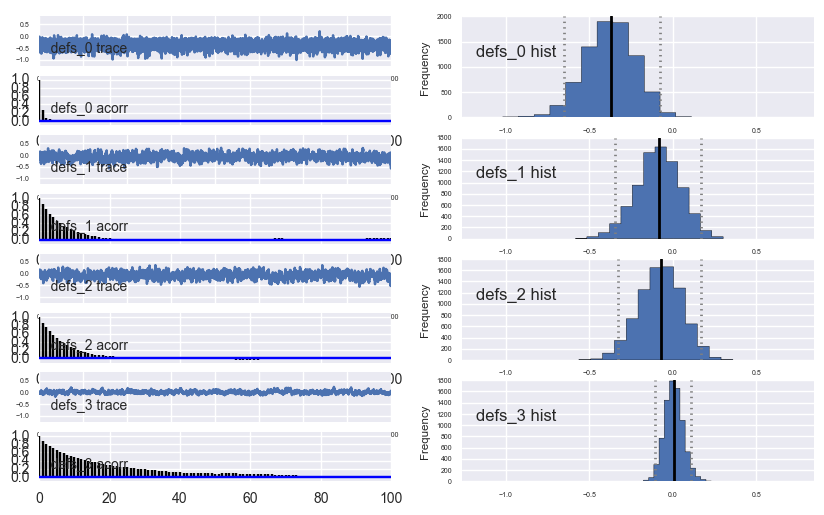

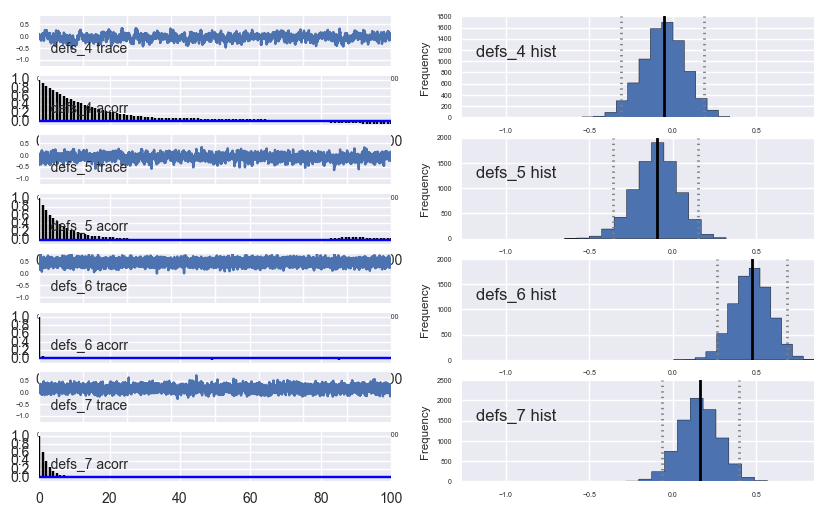

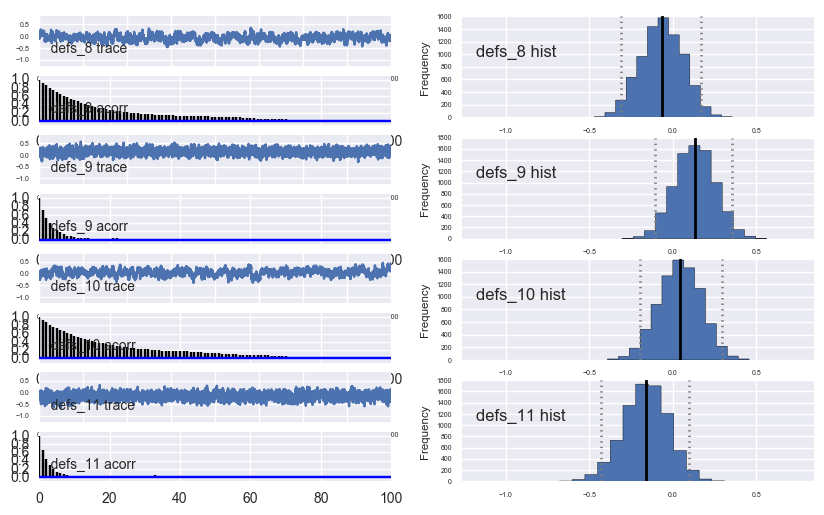

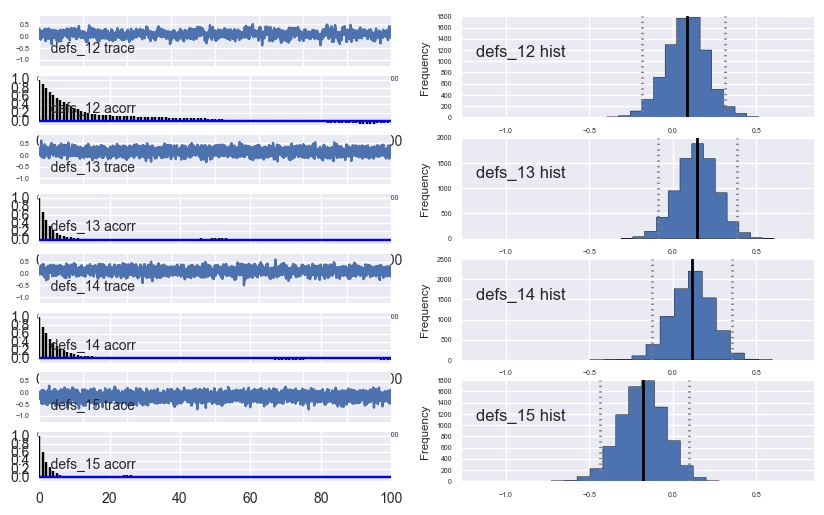

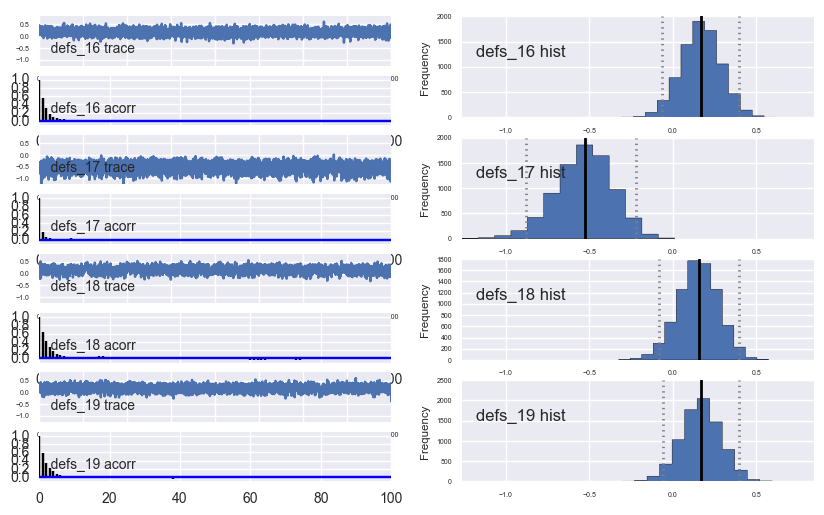

In [10]:
pymc.Matplot.plot(defs)

Plotting tau_att


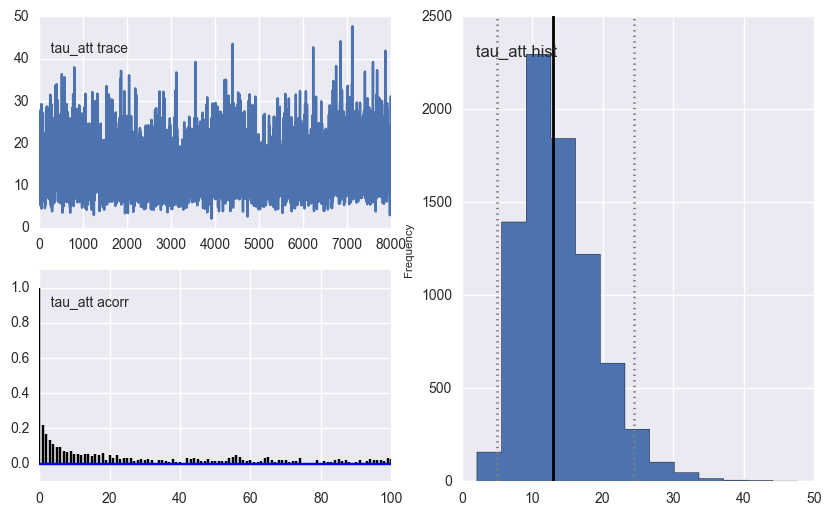

In [11]:
pymc.Matplot.plot(tau_att)

Plotting home


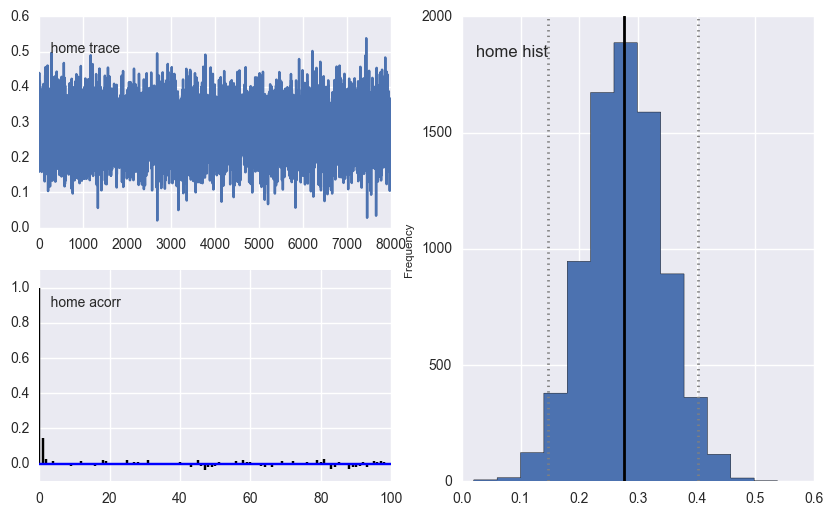

In [12]:
pymc.Matplot.plot(home)

Plotting intercept


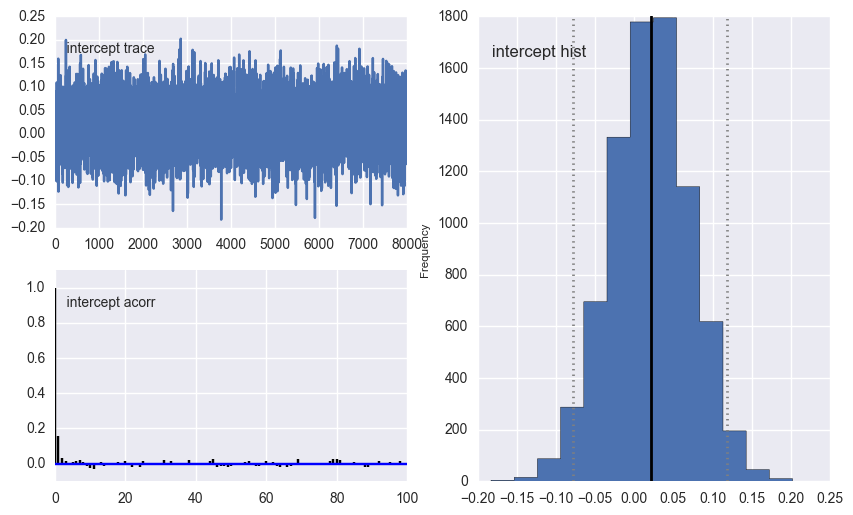

In [13]:
pymc.Matplot.plot(intercept)


# Team ranking

In [14]:
def points(x,y):
    return [(x>y)*3+(x==y),(x<y)*3+(x==y)]


In [15]:

import scipy.stats as ss
df[['home_points','away_points']]=pd.DataFrame(np.transpose(points(df['home_score'],df['away_score'])))
total_scores=df.groupby('away')['away_points'].sum()+df.groupby('home')['home_points'].sum()
ranking=pd.DataFrame(columns=['teams','points'])
ranking['team']=total_scores.keys()
ranking['points']=total_scores.values
ranking['final_rank']=ss.rankdata(-total_scores)

def get_season_outcome(x):
    if x.final_rank<3:
        return 'champs_league'
    elif x.final_rank<5:
        return 'europa_league'
    elif x.final_rank>17: 
        return 'relegation'
    else:
        return ''

ranking['QR']=ranking.apply(get_season_outcome,axis=1)


In [16]:
ranking

,teams,points,team,final_rank,QR
0,NaN,37,Ajaccio GFCO,19.0,relegation
1,NaN,50,Angers,10.0,
2,NaN,50,Bastia,10.0,
3,NaN,50,Bordeaux,10.0,
4,NaN,54,Caen,7.0,
5,NaN,44,Guingamp,16.0,
6,NaN,60,Lille,5.0,
7,NaN,46,Lorient,15.0,
8,NaN,65,Lyon,2.5,champs_league
9,NaN,48,Marseille,13.5,


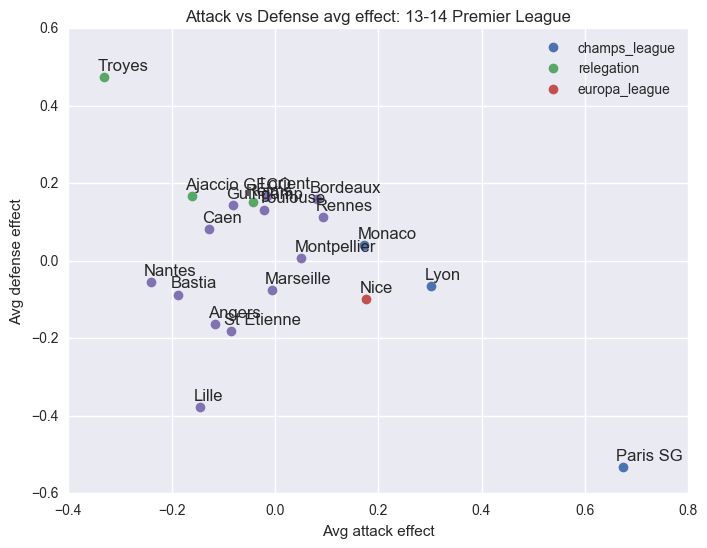

In [17]:
df_observed =ranking
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']}, 
                      index=teams.team.values)
df_avg = pd.merge(df_avg, df_observed, left_index=True, right_on='team', how='left')

fig, ax = plt.subplots(figsize=(8,6))
for outcome in ['champs_league', 'relegation', 'europa_league', '']:
    ax.plot(df_avg.avg_att[df_avg.QR == outcome], 
            df_avg.avg_def[df_avg.QR == outcome], 'o', label=outcome)
    
for label, x, y in zip(df_avg.team.values, df_avg.avg_att.values, df_avg.avg_def.values):
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
ax.set_title('Attack vs Defense avg effect: 13-14 Premier League')
ax.set_xlabel('Avg attack effect')
ax.set_ylabel('Avg defense effect')
ax.legend()

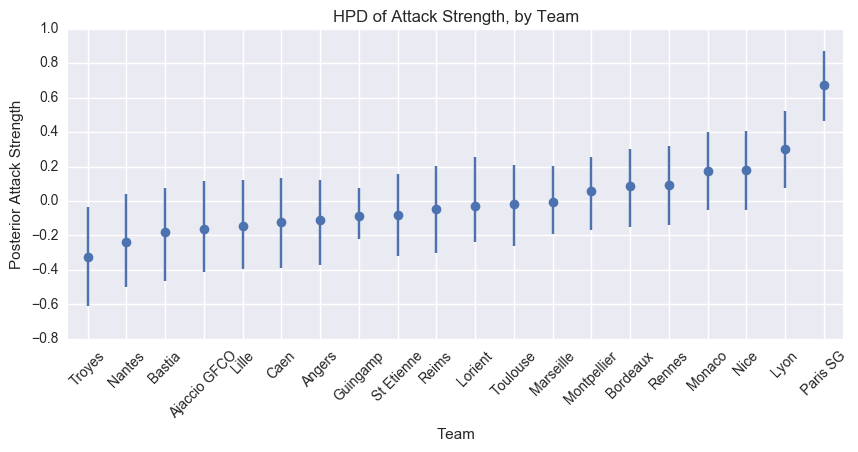

In [18]:
df_hpd = pd.DataFrame(np.transpose(atts.stats()['95% HPD interval']), 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [22]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    
    season['home_coef'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home_coef'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season['outcome'] = season.apply(lambda x: 'away' if x['home_goals'] < x['away_goals'] else 
                                                    'home' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  
    
def simulate_seasons_tables(n_seasons=100):
    dfs = []
    for i in range(n_seasons):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [20]:
simulate_season()

,home,away,home_score,away_score,i_home,i_away,home_points,away_points,att_home,def_home,...,away_goals,home_outcome,away_outcome,outcome,home_draw,home_loss,home_win,away_draw,away_loss,away_win
0,Lille,Paris SG,0.0,1.0,0,17,0,3,-0.338223,-0.324301,...,2,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
90,Bastia,Paris SG,0.0,2.0,1,17,0,3,-0.192396,-0.270570,...,0,win,loss,home,0.0,0.0,1.0,0.0,1.0,0.0
249,Marseille,Paris SG,1.0,2.0,2,17,0,3,0.076088,-0.061600,...,0,win,loss,home,0.0,0.0,1.0,0.0,1.0,0.0
20,Montpellier,Paris SG,0.0,1.0,3,17,0,3,0.071020,0.015569,...,4,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
73,Nantes,Paris SG,1.0,4.0,4,17,0,3,-0.309343,-0.246059,...,0,draw,draw,draw,1.0,0.0,0.0,1.0,0.0,0.0
160,Nice,Paris SG,0.0,3.0,5,17,0,3,0.432785,0.083908,...,4,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
299,Troyes,Paris SG,0.0,9.0,6,17,0,3,-0.489592,0.344973,...,7,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
369,Bordeaux,Paris SG,1.0,1.0,7,17,1,1,-0.133206,0.082180,...,3,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
275,Lyon,Paris SG,2.0,1.0,8,17,3,0,0.394316,-0.098052,...,2,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0
205,Toulouse,Paris SG,0.0,1.0,9,17,0,3,-0.303395,0.166726,...,3,loss,win,away,0.0,1.0,0.0,0.0,0.0,1.0


In [30]:
n_seasons=1000
simuls = simulate_seasons_tables(n_seasons)


In [ ]:
simuls

In [ ]:
team='Lyon'
ax = simuls.points[simuls.team == team].hist(figsize=(7,5))
median = simuls.points[simuls.team == team].median()
ax.set_title(team+': 2015-16 points,  simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))
obs_points=ranking[ranking.team==team].iloc[0,1]
ax.plot([obs_points,obs_points ], ax.get_ylim())
plt.annotate('Oberved points: %s' % obs_points, xy=(obs_points + 1, ax.get_ylim()[1]-30))


In [ ]:
season=simulate_season()

# Probabilities

In [56]:
def simulate_probas(n_seasons=100):
    probas=pd.get_dummies(simulate_season()['outcome'])
    for i in range(n_seasons-1):
        probas=probas+pd.get_dummies(simulate_season()['outcome'])
    probas=probas/n_seasons
    probas.columns=['away_proba','draw_proba','home_proba']
    return probas
probas=simulate_probas(1000) #the outcome is given for the home team

In [55]:
probas

,away,draw,home
0,0.557,0.276,0.167
90,0.655,0.220,0.125
249,0.611,0.237,0.152
20,0.630,0.205,0.165
73,0.662,0.203,0.135
160,0.584,0.217,0.199
299,0.849,0.109,0.042
369,0.692,0.171,0.137
275,0.592,0.204,0.204
205,0.695,0.186,0.119


In [24]:
def proba_match(home_team,away_team,probas):
    i=df[df.home==home_team][df.away==away_team].index
    res= pd.DataFrame(probas.iloc[i])
    res.columns=[away_team,'Nul',home_team]
    return res

proba_match("Lyon","Bastia",probas)
    
    


,Bastia,Nul,Lyon
304,0.188,0.216,0.596


# Scores distributions

In [25]:
def goal_distribution(n_seasons=100):
    dfs=[]
    for i in range(n_seasons):
        s = simulate_season()
        #s['iteration'] = i
        dfs.append(s[['home','away','home_goals','away_goals','home_score','away_score']])
    dfs=pd.concat(dfs, ignore_index=True)
    #grouped=dfs.groupby(['home','away','home_goals'])
    return dfs

In [26]:
dfs=goal_distribution()

In [27]:
def distribution_plot(home_team,away_team,goal_distribution,n_seasons=100):

    data_to_hist=dfs[dfs['home']==home_team][dfs['away']==away_team]
    obs_vars=['home_score','away_score']
    variables=['home_goals','away_goals']
    titles=[home_team,away_team]
    
    f,a = plt.subplots(1,2)
    a = a.ravel()
    for idx,ax in enumerate(a):
        ax.hist(data_to_hist[variables[idx]])
        ax.set_title(titles[idx])
        obs_score=data_to_hist[obs_vars[idx]].mean()
        ax.plot([obs_score, obs_score], ax.get_ylim())
        ax.annotate('Observed score: %s' % obs_score, xy=(obs_score + 0.1, ax.get_ylim()[1]-10))
    plt.tight_layout()

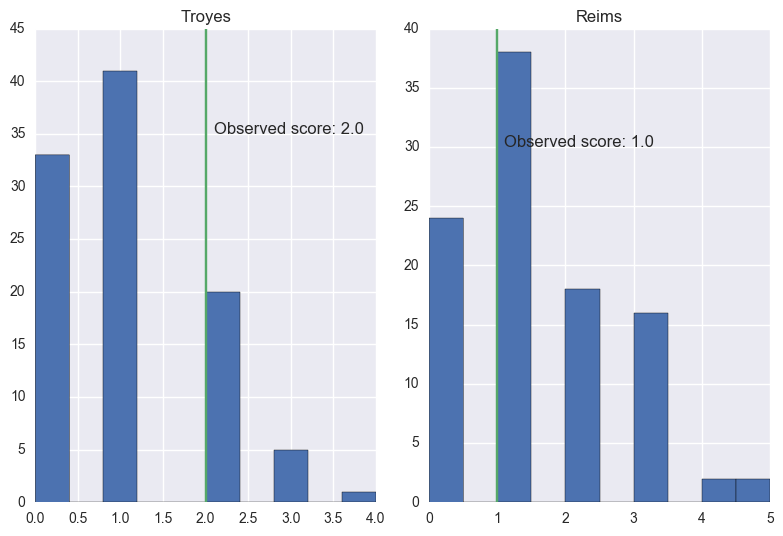

In [28]:
home_team=np.random.choice(teams['team'])
away_team=np.random.choice(teams['team'])
while away_team==home_team:
    away_team=np.random.choice(teams['team'])
distribution_plot(home_team,away_team,dfs)

,home,away,home_score,away_score,i_home,i_away,home_points,away_points
0,Lille,Paris SG,0.0,1.0,0,17,0,3
1,Bastia,Rennes,2.0,1.0,1,14,3,0
2,Marseille,Caen,0.0,1.0,2,12,0,3
3,Montpellier,Angers,0.0,2.0,3,11,0,3
4,Nantes,Guingamp,1.0,0.0,4,13,3,0
5,Nice,Monaco,1.0,2.0,5,10,0,3
6,Troyes,Ajaccio GFCO,0.0,0.0,6,19,1,1
7,Bordeaux,Reims,1.0,2.0,7,18,0,3
8,Lyon,Lorient,0.0,0.0,8,16,1,1
9,Toulouse,St Etienne,2.0,1.0,9,15,3,0


# Evaluate the probabilities

In [47]:
score_probas=pd.concat([df,probas],axis=1)

In [80]:
def get_outcome(results):
    if results['home_score'] > results['away_score']:
        return 'home' 
    elif results['home_score'] < results['away_score']:
        return 'away'
    else: 
        return 'draw'

def get_pred(probas):
    i=np.argmax(probas)
    d={'away','draw', 'home'}
    return i[:-6]

In [96]:
score_probas['prediction']=probas.apply(get_pred,axis=1)
score_probas["game_outcome"]=df.apply(get_outcome,axis=1)

right_preds=(score_probas['prediction']==score_probas["game_outcome"]).sum()
print("Accuracy: "+str(float(right_preds)/float(len(score_probas))))

Accuracy: 0.489473684211
